### Skimpy simulation 
This notebook is purely for making the simulation framework

In [1]:
#load packages
from pytfa.io.json import load_json_model
from skimpy.io.yaml import  load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.core.parameters import ParameterValues
from skimpy.utils.namespace import *
import pandas as pd
import numpy as np
import skimpy
import time
import matplotlib.pyplot as plt
import itertools
import matplotlib
import sys

from skimpy.core.modifiers import *
from skimpy.io.yaml import load_yaml_model
from skimpy.core.reactor import Reactor
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations, load_fluxes
from skimpy.viz.plotting import timetrace_plot
from pytfa.io.json import load_json_model
from skimpy.io.yaml import load_yaml_model
from skimpy.analysis.oracle.load_pytfa_solution import load_concentrations
from skimpy.core.parameters import load_parameter_population
from skimpy.simulations.reactor import make_batch_reactor
from skimpy.core.solution import ODESolutionPopulation
from skimpy.utils.namespace import *
from skimpy.viz.escher import animate_fluxes, plot_fluxes
import copy
from skimpy.io.yaml import export_to_yaml
from skimpy.analysis.ode.utils import make_flux_fun

In [2]:
def setup_ode_system(kmodel,tmodel,ref_solution):    
    # Units of the parameters are muM and hr
    CONCENTRATION_SCALING = 1e6  
    TIME_SCALING = 1 # 1hr to 1min
    DENSITY = 1200 # g/L
    GDW_GWW_RATIO = 0.3 # Assumes 70% Water
    
    #load relevant input files
    kmodel =  load_yaml_model(kmodel)
    tmodel = load_json_model(tmodel)
    ref_solution=pd.read_csv(ref_solution,index_col=0).loc['strain_1',:]
    
    # concentration of the metabolites |
    ref_concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                         concentration_scaling=CONCENTRATION_SCALING)
    #To run dynamic simulations, the model needs to contain compiled ODE expressions
    # help(kmodel.prepare()): Model preparation for different analysis types. The preparation is done
    #before the compling step
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)
    kmodel.prepare()
    kmodel.compile_ode(sim_type=QSSA, ncpu=8)
    
    for k in kmodel.initial_conditions:
        kmodel.initial_conditions[k] = ref_concentrations[k]
    
    return kmodel, ref_concentrations,tmodel
#print(b-a) #26 seconds

def setup_batch_reactor(filenames):
    reactor=make_batch_reactor(filenames['batch_file'])
    reactor.compile_ode(add_dilution=False)# check later what dilution does, it says dilution of intracellular metabolites
    tmodel=load_json_model(filenames['tmodel'])
    bkmodel=load_yaml_model(filenames['batch_kmodel'])
    reference_solutions=pd.read_csv(filenames['ref_solution'],index_col=0)
    ref_concentrations= load_concentrations(reference_solutions.loc['strain_1'], tmodel, bkmodel,
                                                      concentration_scaling=reactor.concentration_scaling)
    reactor.initial_conditions['biomass_strain_1'] = 0.1e12 # Number of cells
    reactor.initialize(ref_concentrations, 'strain_1')
    reactor.initialize(ref_concentrations, 'strain_2')
    return reactor, reference_solutions


def ode_integration(kmodel,met_plots,plotting=True):
    sol=kmodel.solve_ode(np.linspace(0,25,4000),solver_type="cvode") 
    if plotting==True:
        time=sol.time
        concentrations=sol.concentrations

        for i in met_plots:
            plt.plot(time,concentrations[i],label=i)
            plt.xlabel("Time (in s)")
            plt.ylabel("Concentration")
            plt.legend()
        plt.show()
    else:
        pass
    return sol

def perturb_kmodel(kmodel, enz_dict_perturb,parameter_values):
    #this function works for both the kinetic model and reactor object
    n=len(enz_dict_perturb.keys())
    
    #this is required because python passes mutable objects
    kmodel.parameters = parameter_values 
    
    #perturb model: if only 1 value, or more perturbations
    perturbed_kmodel=kmodel #not overwriting the wt_model 
    if n==1:
        enz_label=list(enz_dict_perturb.keys())[0]
        enz_level=list(enz_dict_perturb.values())[0]
        perturbed_kmodel.parameters[enz_label].value=perturbed_kmodel.parameters[enz_label].value*enz_level
    else:
        enz_label=list(enz_dict_perturb.keys())
        enz_level=list(enz_dict_perturb.values())
        for i,k in enumerate(enz_label):
            perturbed_kmodel.parameters[k].value=perturbed_kmodel.parameters[k].value*enz_level[i]
    return perturbed_kmodel


def generate_perturbation_scheme_reactor(enz_names,perturbation_range):
    temp=[]
    for i in enz_names:
        temp2="strain_1_"+i #add strain name
        temp.append(temp2)
    enz_names=temp
    ndim=len(enz_names)
    dim_range_list=[]
    for i in range(ndim):
        dim_range_list.append(np.array(perturbation_range))
    #Cartesian product
    cart=[]
    for element in itertools.product(*dim_range_list):
        cart.append(element)
    design_list=[]
    for i in range(len(cart)):
        values=tuple(cart[i])
        design=dict(zip(enz_names,values))
        design_list.append(design)
    return design_list,cart

def generate_perturbation_scheme(enz_names,perturbation_range): #also here make sure
    """Given the perturbation profile,create a dictionary
    Input:
    perturbation_range: perturbation value of vmax w.r.t. wildtype
    ndim: the number of fluxes to consider
    
    Output of dictionaries
    """
    ndim=len(enz_names)
    dim_range_list=[]
    for i in range(ndim):
        dim_range_list.append(np.array(perturbation_range))
    #Cartesian product
    cart=[]
    for element in itertools.product(*dim_range_list):
        cart.append(element)
    design_list=[]
    for i in range(len(cart)):
        values=tuple(cart[i])
        design=dict(zip(enz_names,values))
        design_list.append(design)
    return design_list,cart


def relative_met_change(sol_wt,sol_ps):
    difference=sol_ps.species-sol_wt.species
    difference=np.mean(difference[-5:-1,:],0)
    wt_avg=np.mean(sol_wt.species[-5:-1,:],0)
    x=difference/wt_avg
    rel_decrease=(1+x)
    return rel_decrease

def relative_flux_change(flux_wt,flux_mt):
    flux_w=np.array(list(flux_wt.values()))
    flux_m=np.array(list(flux_mt.values()))
    difference=flux_m-flux_w
    x=difference/flux_w
    rel_decrease=(1+x)
    
    return rel_decrease

def plot_energy_landscape(rel_change,metabolite,enzymes,enz_ind):
    coordinate_list=[]
    #find the coordinates (number of enzymes), and put them in a list
    for i in range(np.shape(rel_change[metabolite])[0]):
        coordinates=rel_change[metabolite].index[i]
        coordinate_list.append(coordinates)
    number_of_dimensions=len(coordinate_list[0])
    unique_heatmap_dims=[0]*number_of_dimensions
    for i in range(number_of_dimensions):
        dim_list=[]
        for k in range(len(coordinate_list)):
            ith_dim_coord=coordinate_list[k][i]
            dim_list.append(ith_dim_coord)
        dim_list=np.unique(dim_list)
        unique_heatmap_dims[i]=dim_list
    #print(unique_heatmap_dims)     
    matrix=np.zeros((len(unique_heatmap_dims[0]),len(unique_heatmap_dims[0])))
    matrix=pd.DataFrame(matrix, index=list(unique_heatmap_dims[enz_ind[0]]) ,
                                           columns=list(unique_heatmap_dims[enz_ind[1]]))
    #now for the coordinates, find the coordinate of the metabolite of interest index i
    #fill in the matrix based on the x_coordinate
    for i in range(np.shape(rel_change[metabolite])[0]):
        coordinates=rel_change[metabolite].index[i]
        #x_coordinate: vmax_forward_pfk will become the rows
        #ycoordinate: vmax_forward_LDH_d will become the columns
        x_coord=np.where(coordinates[enz_ind[0]]==matrix.index)[0] 
        y_coord=np.where(coordinates[enz_ind[1]]==matrix.columns)[0]
        temp_mat=np.array(matrix)
        #fill in the values of the list 
        temp_mat[x_coord,y_coord]=rel_change[metabolite].values[i]
        matrix=pd.DataFrame(temp_mat, index=list(unique_heatmap_dims[enz_ind[0]]) ,
                                           columns=list(unique_heatmap_dims[enz_ind[1]])) 
    #Apparently, here it goes wrong
    fig,ax=plt.subplots()
    im = ax.imshow(matrix.T,cmap='Reds')
    fig.colorbar(im)
    ax.set_xticks(np.arange(np.shape(matrix)[0]))
    ax.set_xticklabels(np.array(matrix.index))
    ax.set_yticks(np.arange(np.shape(matrix)[0]))
    ax.set_yticklabels(np.array(matrix.columns))
    ax.invert_yaxis()
    plt.xlabel(enzymes[enz_ind[0]])
    plt.ylabel(enzymes[enz_ind[1]])
    plt.xticks(rotation=-45)

    plt.title("Relative flux change in"+" reaction G")
    plt.legend()
    plt.show()
    return matrix,fig


def energy_function(rel_change,metabolite_names,weights):
    # A linear weighted function for engineering purposes
    # Input:
    # - weights for the metabolites of interest
    #-relchange matrix
    # Output:
    # -energy landscape for the metabolites of interest (later perhaps also biomass, or whatever)
    norm=np.sum(weights)
    weights=weights/norm
    row_names=rel_change.index
    met_of_interest=[]
    indices=list(rel_change.columns)
    for i in range(len(indices)):
        if indices[i] in metabolite_names:
            met_of_interest.append(i)
    rel_change=rel_change.iloc[:, met_of_interest] 
    for i in  range(np.shape(rel_change)[1]):
        x=list(rel_change.iloc[:,i]*weights[i])
        rel_change.iloc[:,i]=x
    energy=np.sum(rel_change,1)
    return energy


def find_max_coord(relative_met_change,metab_of_int,designs):
    #finds the coordinate of the maximum, which are the perturbed 
    
    #input: relative metabolite change compared to wildtype
    #input: metabolite of interest, or a weighted combination of multiple metabolites (depending on objective)
    
    #output: coordinates of the maximum (values of perturbation)
    #the index of 
    x=relative_met_change[metab_of_int]
    value=np.where(x==np.max(x))[0]
    maximum=designs[int(value)]
    fold_increase=x[value]
    return maximum,fold_increase

def vmax_finder(parameter_values):
    ### finds the vmax of the reactions along with their value for the initial testing of ML
    # One of the ugliest codes ever written
    symbol=list(parameter_values.keys())
    nonsymbol=[]
    for i in symbol:
        i=str(i)
        nonsymbol.append(i)
    myvmax_values=list(parameter_values.values())
    vmax_dictionary=dict(zip(nonsymbol,myvmax_values))
    the_value=[value for key, value in vmax_dictionary.items() if 'vmax_forward_' in key.lower()]
    the_key=[key for key, value in vmax_dictionary.items() if 'vmax_forward_' in key.lower()] 
    vmax_dictionary=dict(zip(the_key,the_value))
    return vmax_dictionary

In [3]:
# concentration of the metabolites |

#ref_concentrations = load_concentrations(ref_solution, tmodel, kmodel,
#                                         concentration_scaling=CONCENTRATION_SCALING)


def setup_ode_system(kmodel,tmodel,ref_solution):    
    # Units of the parameters are muM and hr
    CONCENTRATION_SCALING = 1e6  
    TIME_SCALING = 1 # 1hr to 1min
    DENSITY = 1200 # g/L
    GDW_GWW_RATIO = 0.3 # Assumes 70% Water
    
    #load relevant input files
    kmodel =  load_yaml_model(kmodel)
    tmodel = load_json_model(tmodel)
    ref_solution=pd.read_csv(ref_solution,index_col=0).loc['strain_1',:]
    ref_solution['I_c']=0
    # concentration of the metabolites |
    ref_concentrations = load_concentrations(ref_solution, tmodel, kmodel,
                                         concentration_scaling=CONCENTRATION_SCALING)
    print(ref_concentrations)
    #To run dynamic simulations, the model needs to contain compiled ODE expressions
    # help(kmodel.prepare()): Model preparation for different analysis types. The preparation is done
    #before the compling step
    parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
    parameter_values = ParameterValues(parameter_values, kmodel)
    kmodel.prepare()
    kmodel.compile_ode(sim_type=QSSA, ncpu=8)
    
    for k in kmodel.initial_conditions:
        kmodel.initial_conditions[k] = ref_concentrations[k]
    
    return kmodel, ref_concentrations,tmodel

## Kinetic model simulation

In [5]:
a=time.time()
filenames={
    "kmodel":"../models/shiki_pathway_testmodel.yml",
    "tmodel":"../models/shiki_pathway_testmodel_thermodynamic.json",
    "ref_solution":"../data/sample06092022.csv",
    "batch_file":"../models/single_species.yaml",
    "batch_kmodel":"../models/kin_varma.yml"}

#kinetic model

kmodel,ref_concentrations,tmodel=setup_ode_system(filenames['kmodel'],filenames['tmodel'],filenames['ref_solution'])
parameter_values = {p.symbol:p.value for p in kmodel.parameters.values()}
parameter_values = ParameterValues(parameter_values, kmodel)

#function in the skimpy package for making fluxes
flux_fun = make_flux_fun(kmodel, QSSA)


met_plots="B_c"
#kinetic model wildtype calculation
sol_wt=ode_integration(kmodel,met_plots,plotting=False)
for i,concentrations in sol_wt.concentrations.iterrows():
            flux_wt=flux_fun(concentrations,parameters=parameter_values)

#enzymes to perturb ,'vmax_forward_PFK'
enz_names=["vmax_forward_Enzyme_A"] #'vmax_forward_LDH_D',
perturb_range=[0,0.25,0.5,1,1.5,2,4,8]


#perturb_range=[1,1.1,1.2]
#for the kinetic model
designs,cart=generate_perturbation_scheme(enz_names,perturb_range) 
rel_list=[]
rel_flux_list=[]
vmax_list=[]

#the perturbation integration
for i in designs:
    pmodel=perturb_kmodel(kmodel,i,parameter_values)
    sol=ode_integration(pmodel,met_plots,plotting=False)
    #vmax dictionary
    perturbed_values = {p.symbol:p.value for p in pmodel.parameters.values()}
    vmax=vmax_finder(perturbed_values)
    vmax_index=list(vmax.keys())
    vmax=list(vmax.values())
    vmax_list.append(vmax)
    
    if sol.ode_solution.message=='Successful function return.':
   
        rel_change=relative_met_change(sol_wt,sol)
        rel_list.append(rel_change)
        
        pmodel_parameters = {p.symbol:p.value for p in kmodel.parameters.values()}
        pmodel_parameters = ParameterValues(parameter_values, pmodel)
        for j,concentrations in sol.concentrations.iterrows():
            
            flux_mt=flux_fun(concentrations,parameters=pmodel_parameters)
        rel_flux=relative_flux_change(flux_wt,flux_mt)
        rel_flux_list.append(rel_flux)
    else:
        my_list=np.zeros(49)
        my_flux_list=np.zeros(65)
        my_list[:]=np.NaN
        my_flux_list[:]=np.NaN
        rel_list.append(my_list)
        rel_flux_list.append(my_flux_list)

# Change in metabolite
rel_change=pd.DataFrame(np.array(rel_list))
rel_change.columns=sol_wt.names
rel_change.index=cart

#Change in flux
rel_flux_change=pd.DataFrame(np.array(rel_flux_list))
rel_flux_change.index=cart
rel_flux_change.columns=list(flux_wt.keys())

vmax=pd.DataFrame(np.array(vmax_list))
vmax.columns=vmax_index
vmax.index=cart
vmax['Enzyme_G']=rel_flux_change['Enzyme_G']

#vmax.to_csv('output/vmax_Enzyme_ABC.csv', index=False)

metabolite="C_c"
#enz_names=['vmax_forward_LDH_D','vmax_forward_GAPD','vmax_forward_PFK']
#plot_energy_landscape(rel_change,metabolite,enz_names,enz_ind=[0,1])

b=time.time()
print(b-a)

2023-05-22 11:38:49,151 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies
2023-05-22 11:38:49,792 - thermomodel_redGEMv1_MergedLMPDsAndBiomass - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K
2023-05-22 11:38:50,168 - Unnamed - WARNING - Non integer stoichiometries found ['LMPD_biomass_c_17_462'] change to integer for linear dependencies


_13dpg_c        44.550000
_2pg_c         465.713616
_3pg_c         220.277278
_4crsol_c    10000.000000
_5drib_c     10000.000000
                 ...     
C_c            894.934355
D_c            999.670854
E_c            999.780557
F_c            999.890273
G_c             44.090619
Length: 92, dtype: float64
44.70611810684204


In [7]:
vmax['Enzyme_G']=np.array(rel_flux_change['Enzyme_G'])


# Plots

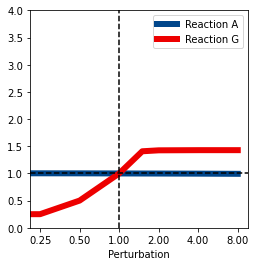

In [6]:
from matplotlib.ticker import ScalarFormatter, LogFormatter


fig = plt.figure()
ax = fig.add_subplot()
perturbed_vmax="vmax_forward_Enzyme_A"
#flux="Enzyme_A"
#flux_n="Reaction A"
#symbol="G"
#plt.plot(cart,rel_flux_change[flux],label=flux_n,color="#42B540FF",linewidth=6)
flux="Enzyme_A"
flux_n="Reaction A"
symbol="A"
#plt.title("Relative Flux Change Enzyme "+symbol)
plt.plot(cart,rel_flux_change[flux],label=flux_n,color="#00468BFF",linewidth=6)
#flux="Enzyme_C"
#flux_n="Reaction C"
#plt.title("Relative Flux Change ")
#plt.plot(cart,rel_flux_change[flux],label=flux_n,color="#925E9FFF",linewidth=6)
flux="Enzyme_G"
flux_n="Reaction G"
symbol="A"
plt.plot(cart,rel_flux_change[flux],label=flux_n,color="#ED0000FF",linewidth=6)
ax.set_xscale('log', base=2)
#ax.set_yscale('log',base=2)
ax.set_box_aspect(1)
for axis in [ax.xaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.axvline(x=1,color="black",linestyle='--')
plt.axhline(y=1,color="black",linestyle='--')
plt.legend()
plt.xlabel("Perturbation")
#plt.ylabel("Relative Flux change")
plt.ylim(0.0,4)
#plt.yticks([])

string_name="ptb_"+str(perturbed_vmax)
#plt.savefig('Results/'+string_name+'.svg')
plt.show()









No handles with labels found to put in legend.


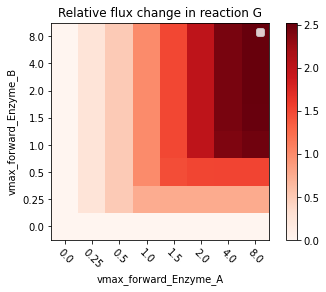

In [17]:
#metabolite="F_c"
#plot1=plot_energy_landscape(rel_change,metabolite,enz_names,enz_ind=[0,1])
#plot2=plot_energy_landscape(rel_change,metabolite,enz_names,enz_ind=[0,2])
#plot3=plot_energy_landscape(rel_change,metabolite,enz_names,enz_ind=[1,2])

metabolite="Enzyme_G"
plot4,fig4=plot_energy_landscape(rel_flux_change,metabolite,enz_names,enz_ind=[0,1])
#plot5,fig5=plot_energy_landscape(rel_flux_change,metabolite,enz_names,enz_ind=[1,2])
#plot6,fig6=plot_energy_landscape(rel_flux_change,metabolite,enz_names,enz_ind=[0,2])
max_coord=find_max_coord(rel_change,"F_c",designs)

# fig4.savefig("../../../Results/Flux.svg",bbox_inches="tight",format='svg', dpi=1200)

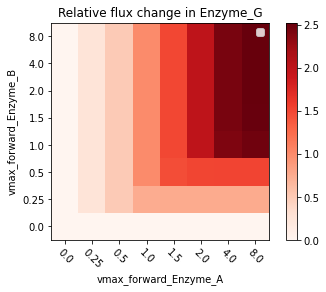

In [7]:
fig4


In [163]:
perturbed_vmax="ABC3"
string_name="comb_ptb"+str(perturbed_vmax)
fig4.savefig('Results/'+string_name+'.svg')